In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

from pathlib import Path
from typing import List

In [2]:
data_folder = Path("../test_results")

## Index logs

In [3]:
index_logs_path = lambda db: Path(data_folder, f"index_logs_{db}_10000000_100.pickle")

In [4]:
def load_data(path: Path) -> dict:
    with open(path, 'rb') as datafile:
        data = pickle.load(datafile)
    return data

In [5]:
es_index_logs = pd.DataFrame(load_data(index_logs_path("elasticsearch"))["performance_results"])
batch_size = es_index_logs["data_size"][0]
es_index_logs["cumulative_size"] = np.cumsum(es_index_logs["data_size"])
es_index_logs["cumulative_time"] = np.cumsum(es_index_logs["time_spent"])

In [6]:
es_index_logs.head()

,data_size,time_spent,cumulative_size,cumulative_time
0,10000,11.915910,10000,11.915910
1,10000,8.363455,20000,20.279366
2,10000,8.362814,30000,28.642180
3,10000,8.340496,40000,36.982676
4,10000,9.366858,50000,46.349533


In [7]:
pg_index_logs = pd.DataFrame(load_data(index_logs_path("postgres"))["performance_results"])
pg_index_logs[pg_index_logs["time_spent"] > 300] = ((pg_index_logs["time_spent"].sum() 
                                                    - pg_index_logs["time_spent"].max())
                                                    / (len(pg_index_logs) - 1))
pg_index_logs["cumulative_size"] = np.cumsum(pg_index_logs["data_size"])
pg_index_logs["cumulative_time"] = np.cumsum(pg_index_logs["time_spent"])

In [8]:
sns.set_theme()

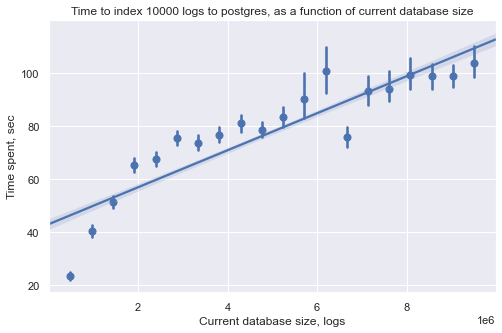

In [9]:
plt.figure(figsize=(8, 5))
plt.title(f"Time to index {batch_size} logs to postgres, as a function of current database size")
sns.regplot(x="cumulative_size", y="time_spent", data=pg_index_logs, x_bins=20)
plt.xlabel("Current database size, logs")
plt.ylabel("Time spent, sec")
plt.show()

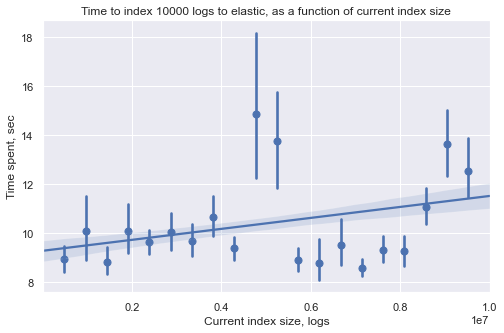

In [10]:
plt.figure(figsize=(8, 5))
plt.title(f"Time to index {batch_size} logs to elastic, as a function of current index size")
sns.regplot(x="cumulative_size", y="time_spent", data=es_index_logs, x_bins=20)
plt.xlabel("Current index size, logs")
plt.ylabel("Time spent, sec")
plt.show()

In [11]:
es_index_logs["database"] = "elastic"
pg_index_logs["database"] = "postgres"
index_logs_df = pd.concat([es_index_logs, pg_index_logs], ignore_index=True)

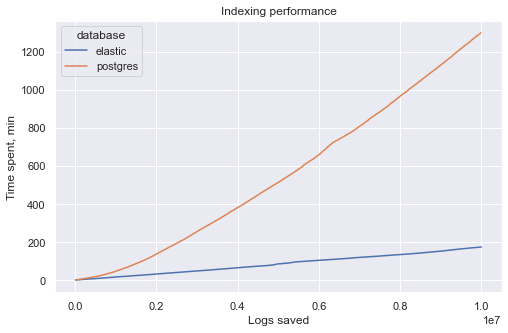

In [12]:
plt.figure(figsize=(8, 5))
plt.title("Indexing performance")
sns.lineplot(x="cumulative_size",
             y=index_logs_df["cumulative_time"]/60,
             hue="database",
             data=index_logs_df)
plt.xlabel("Logs saved")
plt.ylabel("Time spent, min")
plt.show()

## Get logs by ids

In [13]:
get_logs_path = lambda db: Path(data_folder, f"get_logs_by_ids_{db}_10000000_100.pickle")

In [14]:
def unfold_results(results: List[dict]) -> List[dict]:
    undolded_results = []
    for result in results:
        undolded_results += [{"ids_size": result["ids_size"], 
                              "time_spent": time_value} 
                             for time_value in result["time_spent"]]
    return undolded_results

In [15]:
es_get_logs = pd.DataFrame(
    unfold_results(
        load_data(get_logs_path("elasticsearch"))["performance_results"]
    )
)
pg_get_logs = pd.DataFrame(
    unfold_results(
        load_data(get_logs_path("postgres"))["performance_results"]
    )
)
es_get_logs["database"] = "elastic"
pg_get_logs["database"] = "postgres"
get_logs_df = pd.concat([es_get_logs, pg_get_logs], ignore_index=True)
get_logs_df = get_logs_df[get_logs_df["time_spent"] < 5]

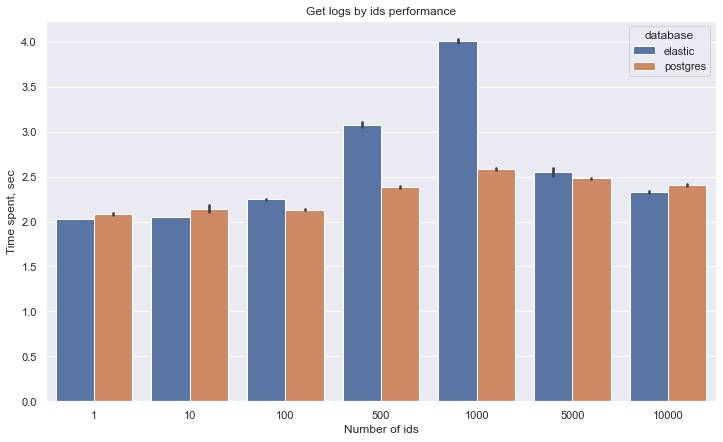

In [16]:
plt.figure(figsize=(12, 7))
plt.title("Get logs by ids performance")
sns.barplot(x="ids_size", y="time_spent", hue="database", data=get_logs_df)
plt.xlabel("Number of ids")
plt.ylabel("Time spent, sec")
plt.show()

## Search logs

In [17]:
search_logs_path = lambda db: Path(data_folder, f"search_logs_{db}_10000000_100.pickle")

In [18]:
es_search_logs = pd.DataFrame({
    "time_spent": load_data(search_logs_path("elasticsearch"))["performance_results"],
    "database": "elastic"
})
pg_search_logs = pd.DataFrame({
    "time_spent": load_data(search_logs_path("postgres"))["performance_results"],
    "database": "postgres"
})
search_logs_df = pd.concat([es_search_logs, pg_search_logs], ignore_index=True)

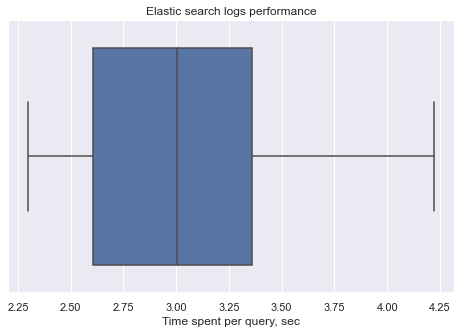

In [19]:
plt.figure(figsize=(8, 5))
plt.title("Elastic search logs performance")
sns.boxplot(x="time_spent", data=search_logs_df[search_logs_df["database"] == "elastic"])
plt.xlabel("Time spent per query, sec")
plt.show()

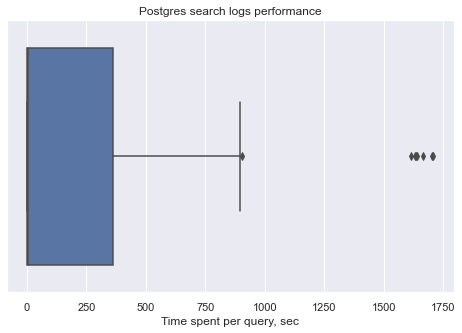

In [20]:
plt.figure(figsize=(8, 5))
plt.title("Postgres search logs performance")
sns.boxplot(x="time_spent", data=search_logs_df[search_logs_df["database"] == "postgres"])
plt.xlabel("Time spent per query, sec")
plt.show()

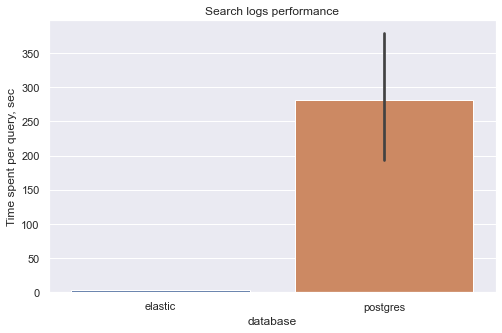

In [21]:
plt.figure(figsize=(8, 5))
plt.title("Search logs performance")
sns.barplot(x="database", y="time_spent", data=search_logs_df)
plt.ylabel("Time spent per query, sec")
plt.show()

In [22]:
print(f"Elastic  average time: {search_logs_df[search_logs_df['database'] == 'elastic']['time_spent'].mean()} s")
print(f"Postgres average time: {search_logs_df[search_logs_df['database'] == 'postgres']['time_spent'].mean()} s")

Elastic  average time: 3.029261655807495 s
Postgres average time: 280.4508772945404 s


## Delete logs

In [23]:
delete_logs_path = lambda db: Path(data_folder, f"delete_logs_{db}_10000000_100.pickle")

In [24]:
es_delete_logs = pd.DataFrame(
    unfold_results(
        load_data(delete_logs_path("elasticsearch"))["performance_results"]
    )
)

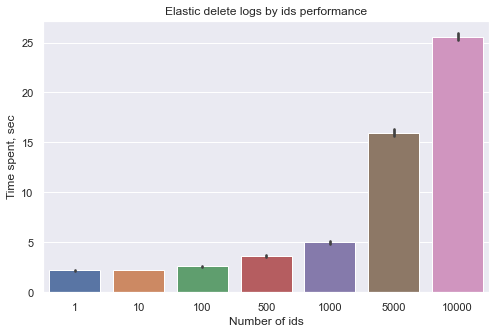

In [25]:
plt.figure(figsize=(8, 5))
plt.title("Elastic delete logs by ids performance")
sns.barplot(x="ids_size", y="time_spent", data=es_delete_logs)
plt.xlabel("Number of ids")
plt.ylabel("Time spent, sec")
plt.show()